# Pendahuluan

Film Junky Union adalah sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

# Konten <a id='back'></a>

* [Pendahuluan](#intro)
* [Konten](#back)
* [1. Inisialisasi](#cont_1)
* [2. Memuat Data](#cont_2)
* [3. EDA](#cont_3)
* [4. Prosedur Evaluasi](#cont_4)
* [5. Normalisasi](#cont_5)
* [6. Pemisahan Train/Test](#cont_6)
* [7. Bekerja dengan Model](#cont_7)
    * [7.1 Model 0 - Konstan](#cont_8)
    * [7.2 Model 1 - NLTK, TF-IDF dan LR](#cont_9)
    * [7.3 Model 2 - spaCy, TF-IDF dan LR)](#cont_10)
    * [7.4 Model 3 - spaCy, TF-IDF dan LGBMClassifier)](#cont_11)
* [8. Ulasan Saya](#cont_12)
    * [8.1 Model 1 - NLTK, TF-IDF dan LR](#cont_13)
    * [8.2 Model 2 - spaCy, TF-IDF dan LR)](#cont_14)
    * [8.3 Model 3 - spaCy, TF-IDF dan LGBMClassifier)](#cont_15)
* [9. Kesimpulan](#cont_16)

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di
tqdm.pandas()

## Memuat data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# menampilkan informasi dataset
print(df_reviews.info())

# menampilkan sampel data
df_reviews.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
29431,tt0284451,movie,Sally,Sally,2000,\N,79,0,"Drama,Romance",4.6,201,Pretty dreadful movie about several unbalanced...,3,neg,0,test,4017
11238,tt0088512,tvSeries,EastEnders,EastEnders,1985,\N,30,0,"Crime,Drama,Romance",4.7,7352,"Licence fees to watch this trash, And pay for ...",2,neg,0,test,6435
43038,tt0430770,movie,The Women,The Women,2008,\N,114,0,"Comedy,Drama",5.0,19984,I will freely admit that I haven't seen the or...,7,pos,1,test,5258
32265,tt0227538,movie,Spy Kids,Spy Kids,2001,\N,88,0,"Action,Adventure,Comedy",5.5,105614,All the actors in this film seem bored. They a...,4,neg,0,test,12003
39298,tt0166252,movie,The Love Letter,The Love Letter,1999,\N,88,0,"Comedy,Drama,Romance",5.5,4031,"""The Love Letter"" is one of those movies that ...",4,neg,0,test,574


Dataset berisi kolom-kolom dengan penjelasan berikut:

- `tconst` — ID unik untuk setiap entitas di basis data IMDb.
- `title_type` — tipe judul entitas (misalnya, film, serial TV, dll.).
- `primary_title` — judul utama dari entitas.
- `original_title` — judul asli dari entitas (misalnya, judul dalam bahasa asli).
- `start_year` — tahun mulai perilisan entitas.
- `end_year` — tahun akhir perilisan (jika berlaku), atau tanda khusus jika entitas masih berlanjut.
- `runtime_minutes` — durasi entitas dalam menit.
- `is_adult` — indikator apakah entitas termasuk konten dewasa (1 untuk ya, 0 untuk tidak).
- `genres` — genre-genre yang terkait dengan entitas (dipisahkan oleh koma).
- `average_rating` — rata-rata nilai peringkat entitas.
- `votes` — jumlah suara atau ulasan yang diterima oleh entitas.
- `review` — ulasan atau tinjauan terkait entitas.
- `rating` — nilai peringkat entitas.
- `sp` —  ulasan positif atau ulasan negatif dalam bentuk teks.
- `pos` — ulasan positif atau ulasan negatif dalam bentuk numerik.
- `ds_part` — sumber dataset entitas dari train atau test.
- `idx` — nomor indeks unik yang mewakili baris tertentu dalam dataset.

In [6]:
# mengecek duplikasi dataset
df_reviews.duplicated().sum()

0

Dataset ini tidak memiliki duplikasi data sehingga bisa kita proses lebih lanjut.

## EDA

Selanjutnya, memeriksa jumlah film dan ulasan selama beberapa tahun.

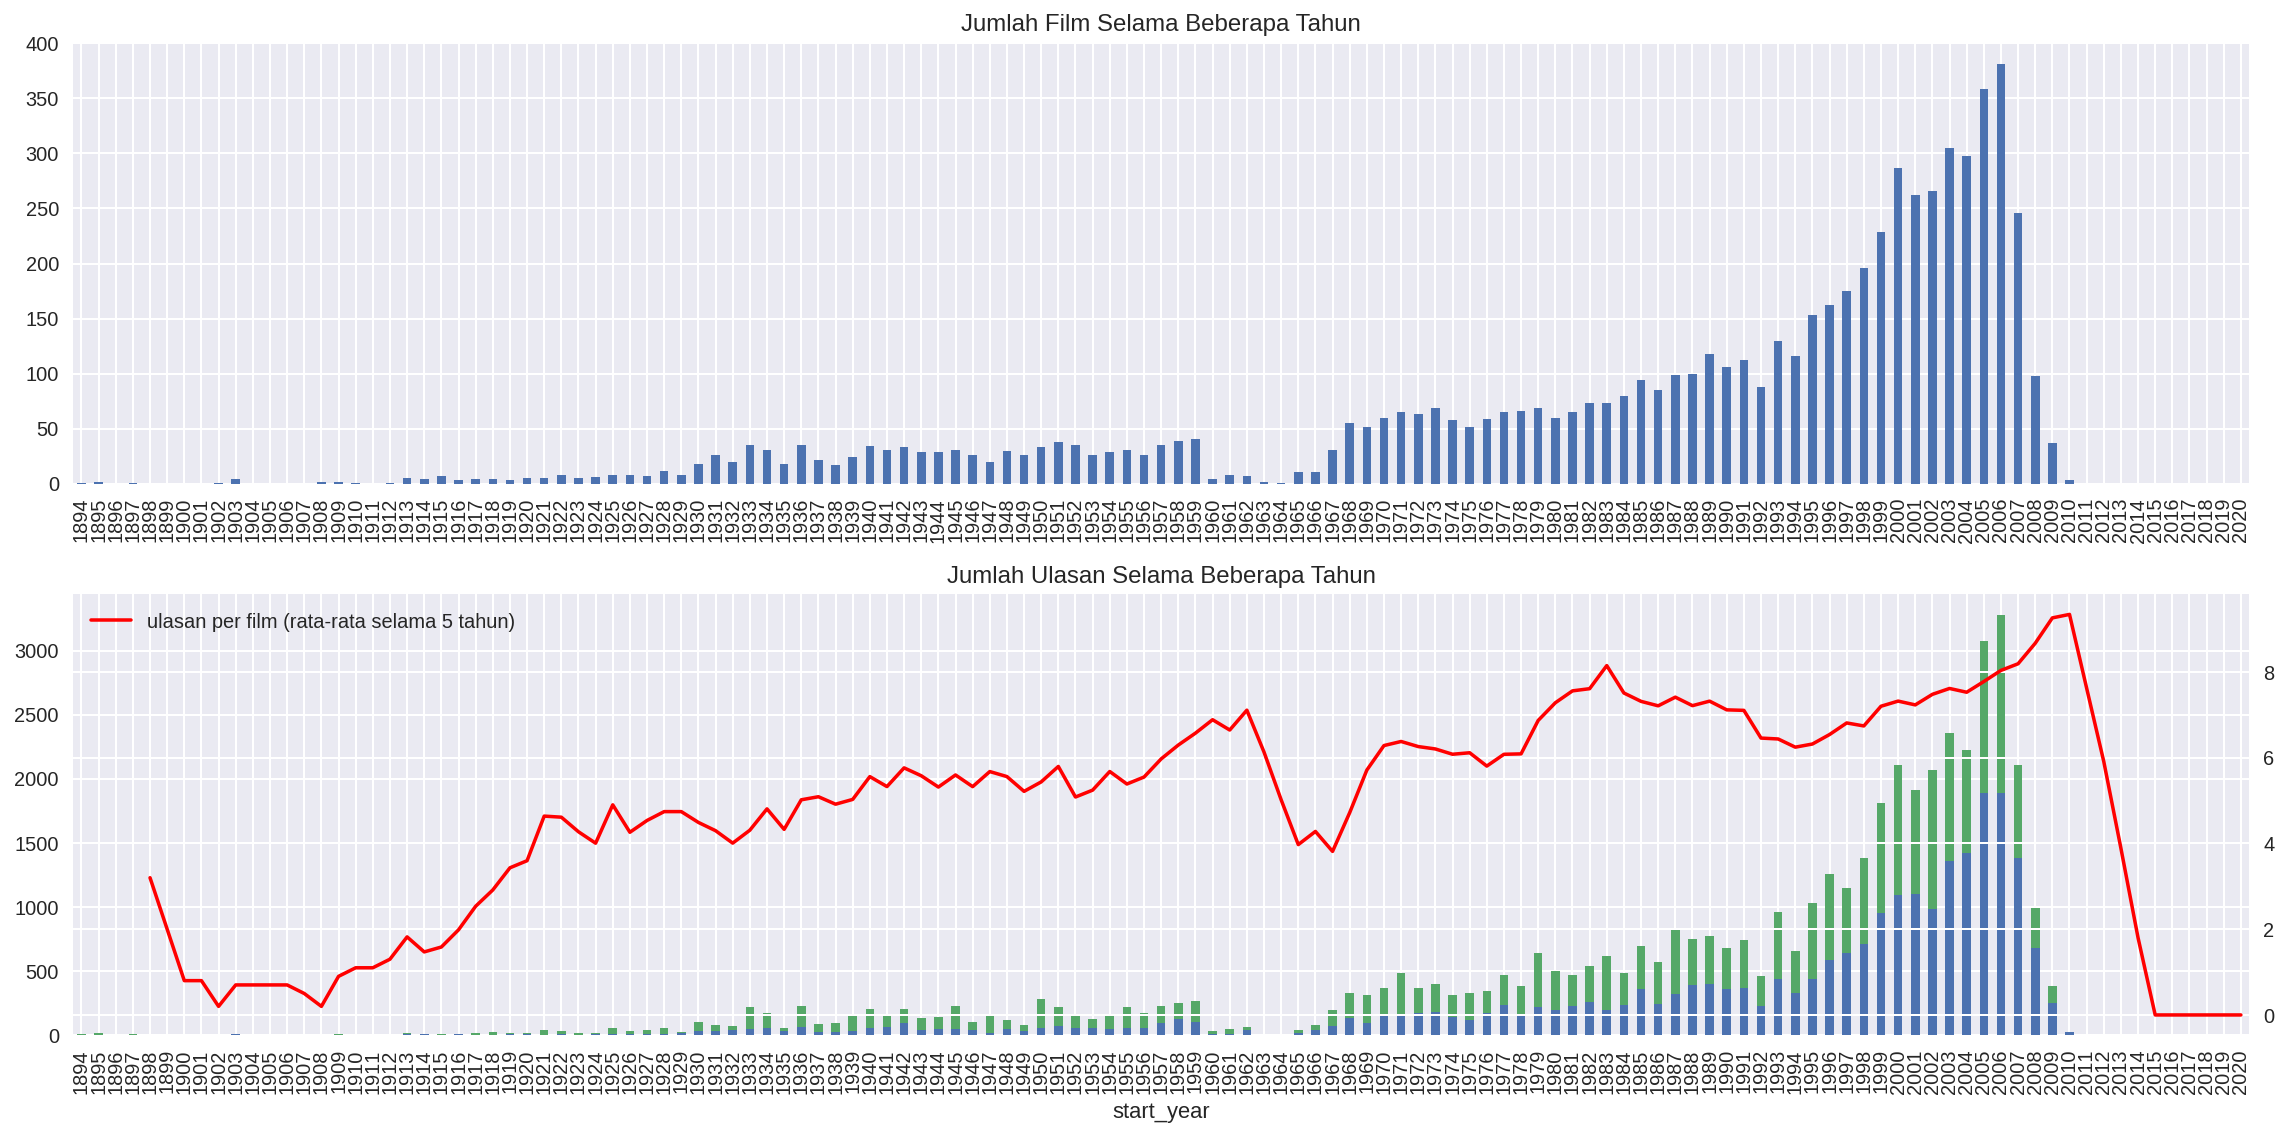

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='red', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Berdasarkan grafik diatas kita dapat menyimpulkan bahwa hampir `setiap tahun mengalami peningkatan jumlah film` yang diikuti dengan `meningkatnya jumlah ulasan` terhadap film tersebut dengan perbandingan `ulasan positif` dan `ulasan negatif` yang hampir `seimbang` hingga tahun `2006`. Jumlah ulasan rata-rata setiap `5 tahun` menunjukan `trend` yang `sedikit meningkat` dari tahun-tahun sebelumnya hingga puncak rata-rata tertinggi tahun `2010` lebih dari `3000 ulasan`.

Dan kita periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

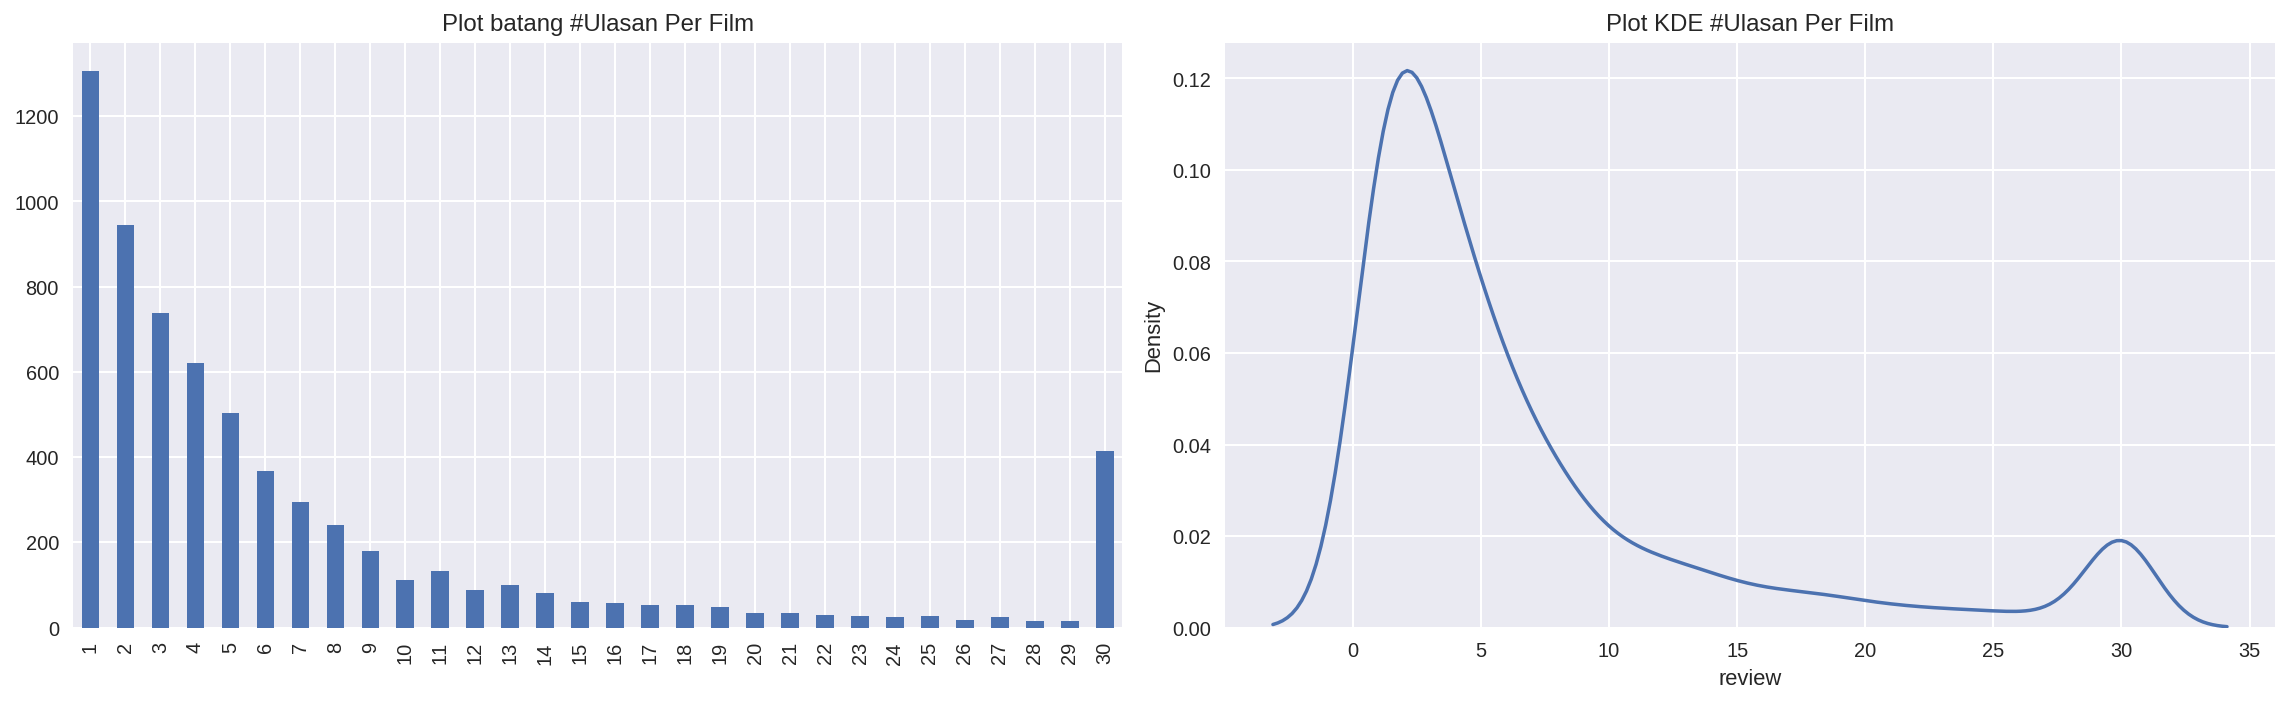

In [8]:
# membuat plot distribusi jumlah ulasan per film
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')
ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

Berdasarkan grafik diatas rata-rata film kebanyakan memiliki ulasan sebanyak `1-5 ulasan/film`, kemudian diikuti dengan film yang memiliki ulasan sebanyak `30 ulasan/film` dan disusul setelahnya.

In [9]:
# menghitung keseimbangan kelas ulasan (negatif [0] dan positif[1])
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

Bisa kita lihat kita memiliki jumlah kelas yang hampir seimbang untuk model klasifikasi dengan `ulasan negatif [0]` dan `ulasan negatif [1]`.

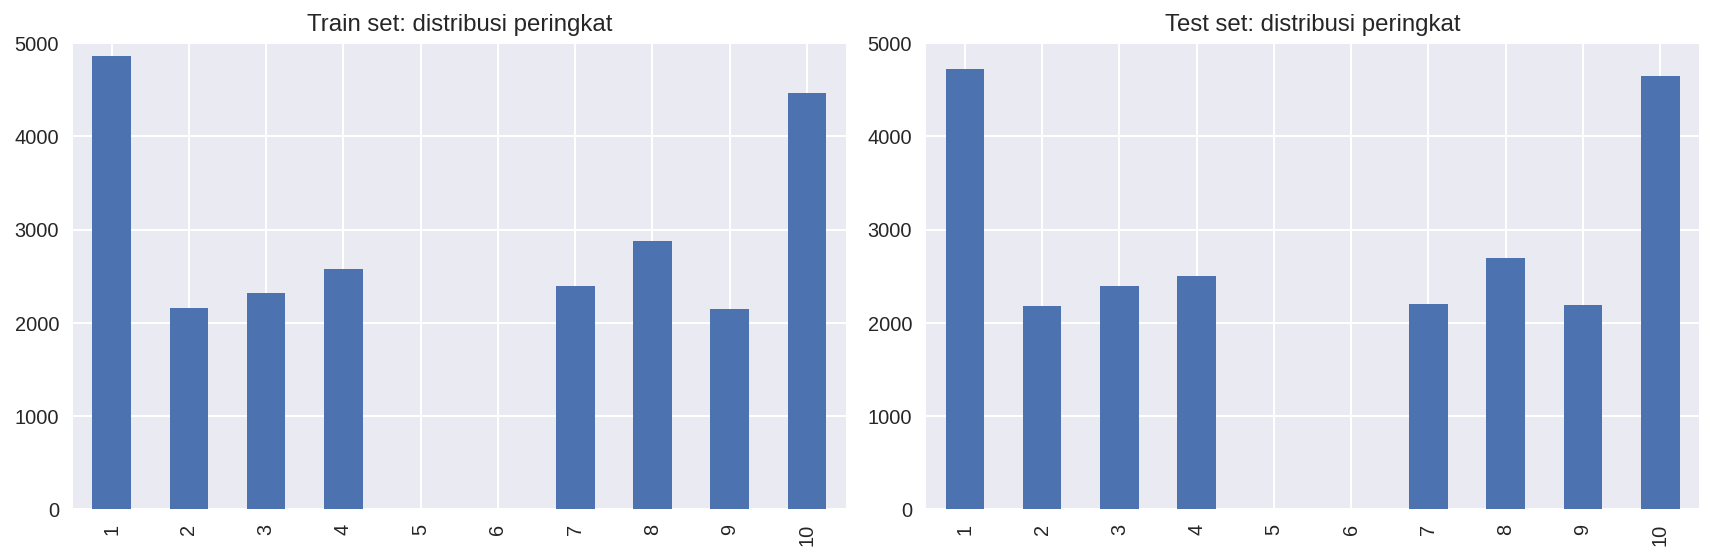

In [10]:
# membuat plot distribusi rating pada dataset training dan dataset test
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Disini kita juga bisa melihat perbadingan jumlah `rating film` yang seimbang, baik untuk dataset `training` maupun dataset `test`. Bisa terlihat jumlah rating terbanyak adalah `1 dan 10` untuk kedua dataset.

Selanjutnya, mengecek distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


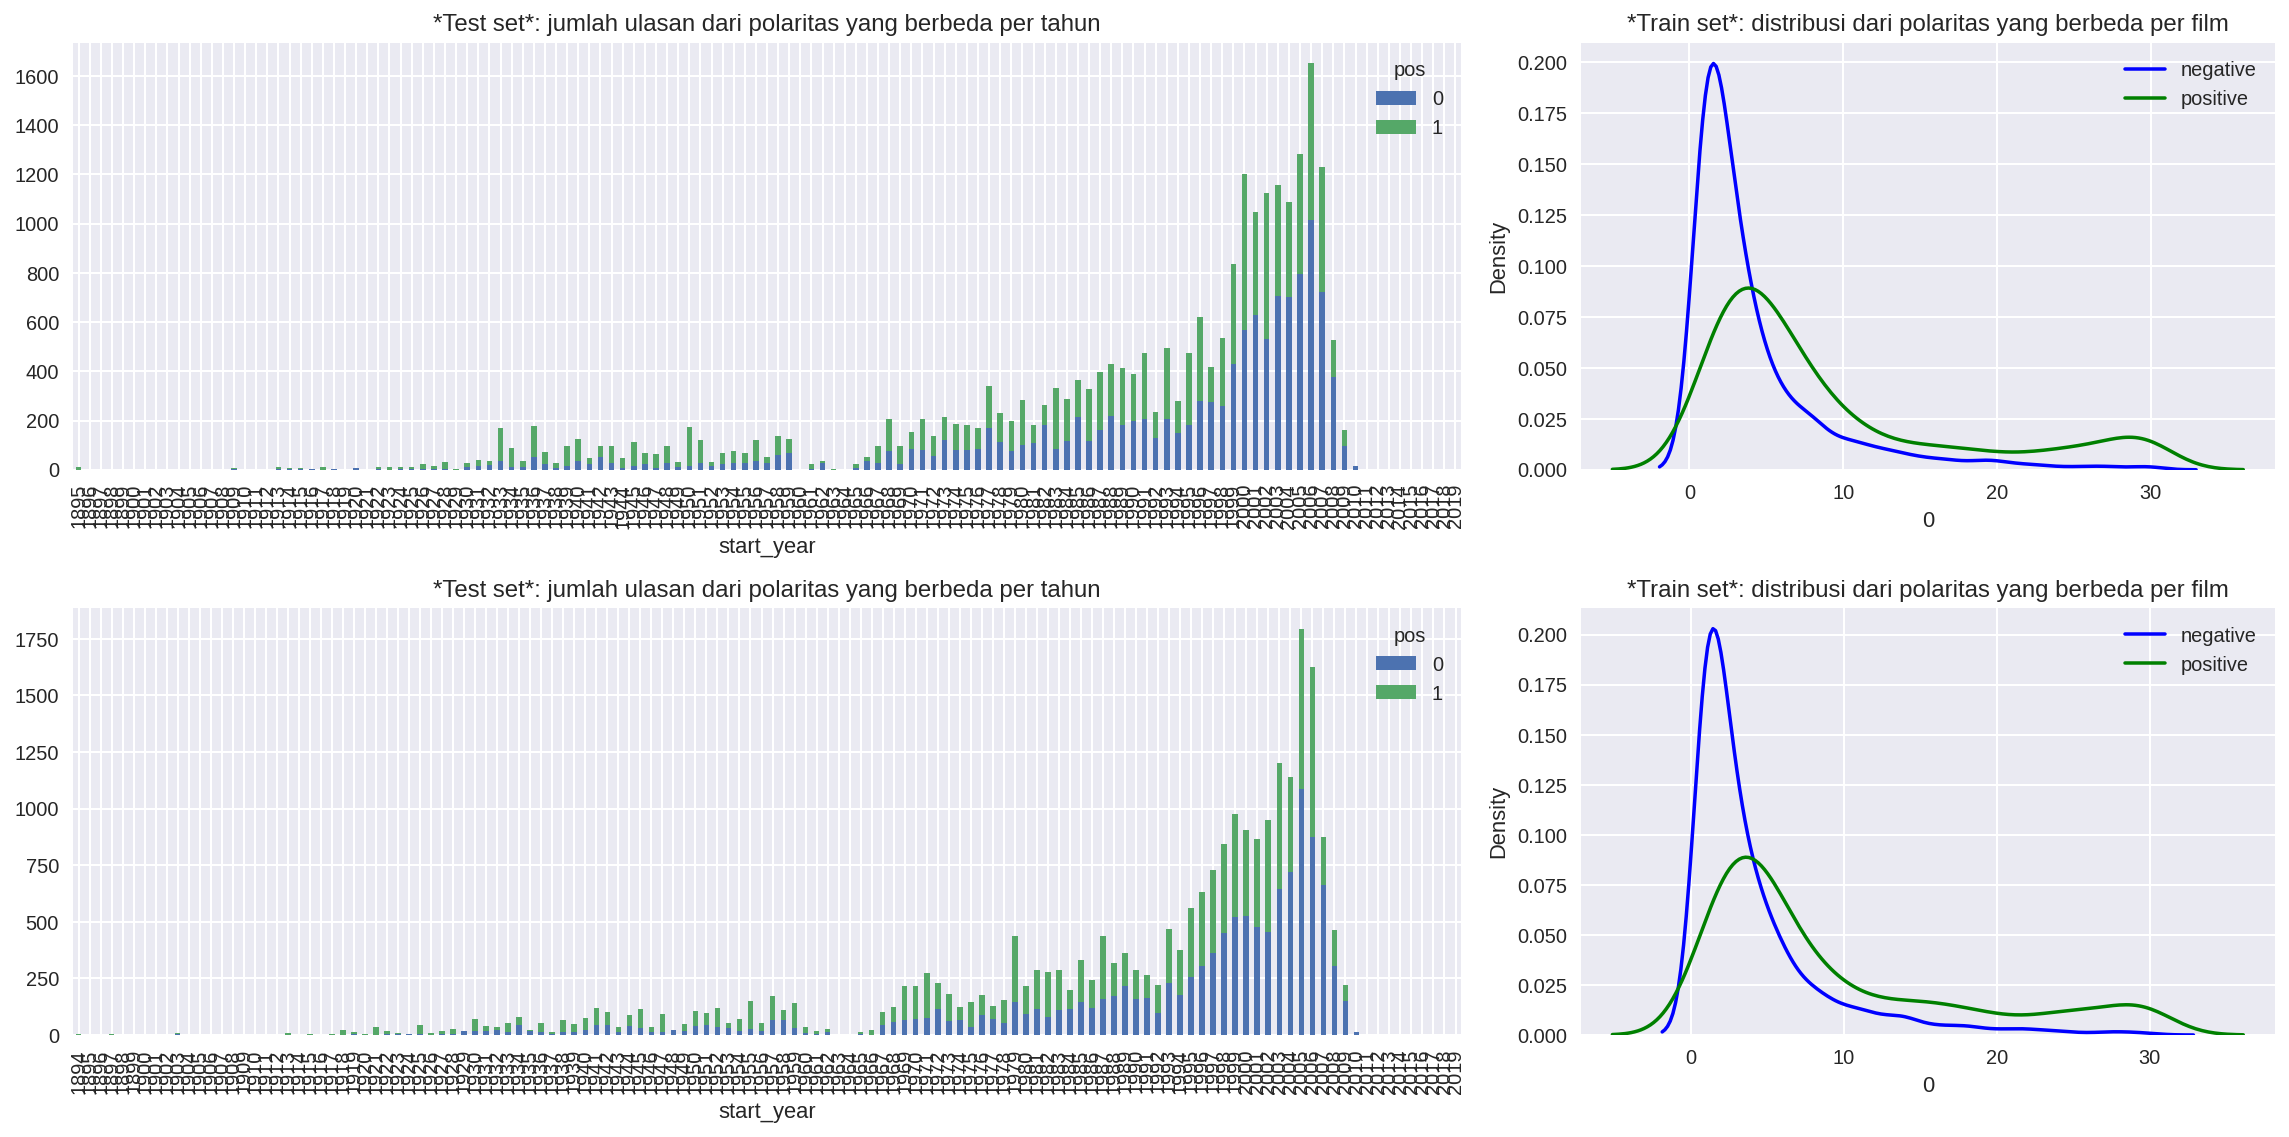

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

Disini bisa kita lihat bentuk dataset `training` dan `test` memiliki kemiripan berdasarkan jumlah `ulasan positif` dan jumlah `ulasan negatif`. Perbandingan jumlah ulasan `positif` dan jumlah ulasan `negatif` yang hampir seimbang untuk masing-masing dataset. Hal tersebut kita bisa langsung menggunakan dataset ini sebagai model latih dan uji pada model-model yang akan kita gunakan tanpa perlu adanya `filtering data`.

## Prosedur Evaluasi

Disini kita akan melakukan evaluasi model terhadap metrik-metrik yang akan kita amati diantaranya: `Akurasi`, `F1 Score`, `Average Precision Score (APS)`, `Area Under the Receiver Operating Characteristic Curve (AUC-ROC)`. Selain itu kita akan melihat kurva dari masing-masing skor, khusus untuk metrik `F1`, `APS` dan `AUC-ROC` serta menghitungnya berdasarkan `threshold`nya.

In [12]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<div class="alert alert-success">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

Hebat, Kerja bagus!

</div>

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [13]:
# sampel sebelum dilakukan normalisasi
df_reviews['review'][1]

'How the hell did they get this made?! Presenting itself as a caper comedy, the misbegotten "$" is essentially two hours of people mumbling sentence fragments. The usually dependable Warren Beatty looks drunk, and the usually hilarious Goldie Hawn acts like she\'s on depressants. As for Gert Frobe, his most famous role - Goldfinger - was infinitely more admirable than his character here. Not even the guy with the champagne bottle of LSD can save this litany of worthlessness. Am I comparing this movie to "Plan 9 from Outer Space"? I wouldn\'t do such a thing even if someone paid me. "P9FOS" was idiotically made but ended up hilarious; this was idiotically made and causes you to feel like your brain just melted out of your ears. Warren Beatty and Goldie Hawn made up for this when they co-starred in "Shampoo", but then they co-starred in the dreadful "Town & Country". Maybe they just shouldn\'t co-star in movies. All in all, I would rather have my skin torn off than have to watch this aga

In [14]:
import re  # tambahkan baris ini untuk mengimpor modul re

# mendefinisikan fungsi untuk menghilangkan angka, tanda baca dan sebagainya
def pre_text(text):
    # mengecilkan huruf dari masing-masing kata
    text = text.lower()
    # mengekstrak kata dengan menghilangkan angka dan tanda baca
    pattern = r"[^a-z\s]"
    text = re.sub(pattern, " ", text)
    text = text.split()
    return ' '.join(text)

# menerapkan fungsi yang sudah dibuat
df_reviews['review_norm'] = df_reviews['review'].apply(pre_text)

In [15]:
# sampel setelah dilakukan normalisasi
df_reviews['review_norm'][1]

'how the hell did they get this made presenting itself as a caper comedy the misbegotten is essentially two hours of people mumbling sentence fragments the usually dependable warren beatty looks drunk and the usually hilarious goldie hawn acts like she s on depressants as for gert frobe his most famous role goldfinger was infinitely more admirable than his character here not even the guy with the champagne bottle of lsd can save this litany of worthlessness am i comparing this movie to plan from outer space i wouldn t do such a thing even if someone paid me p fos was idiotically made but ended up hilarious this was idiotically made and causes you to feel like your brain just melted out of your ears warren beatty and goldie hawn made up for this when they co starred in shampoo but then they co starred in the dreadful town country maybe they just shouldn t co star in movies all in all i would rather have my skin torn off than have to watch this again awful maybe they should remake it wit

Fungsi `pre_text` sudah bisa melakukan tugasnya untuk mengecilkan semua huruf serta membuang angka, tanda baca dan lain sebagainya kecuali `huruf` dan `tanda spasi`.

## Pemisahan Train / Test

Akhirnya, seluruh *dataset* sudah dibagi menjadi *train/test*. BDan kita akan menggunakan 'ds_part' pada dataset pertama.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


In [17]:
# mengecek keseimbangkan kelas pada data train
train_target.value_counts()

0    11912
1    11884
Name: pos, dtype: int64

In [18]:
# mengecek keseimbangkan kelas pada data test
test_target.value_counts()

0    11803
1    11732
Name: pos, dtype: int64

In [19]:
# memisahkan fitur
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']

Semua dataset sudah berhasil dipisahkan menjadi `train` dan `test`. Kemudian masing-masing dataset sudah dipisahkan menjadi `fitur` dan `target` dengan jumlah kelas `ulasan` yang hampir seimbang. Selanjutnya bisa kita proses lebih lanjut.

## Bekerja dengan Model

Kita akan menguji beberapa model beserta pra-pemrosesan kata pada dataset. Beberapa model beserta pra-pemrosesanya:
1. Model-1: Model ini menggunakan `DummyClassifier` dan tanpa pra-pemrosesan dataset.
2. Model-2: Model ini menggunakan `LogisticRegression` dengan pra-pemrosesan lematisasi,stopwords dari NLTK dan vektorisasi TF-IDF.
3. Model-3: Model ini menggunakan `LogisticRegression` dengan pra-pemrosesan lematisasi,stopwords dari spaCy dan vektorisasi TF-IDF.
4. Model-4: Model ini menggunakan `LightGBM` dengan pra-pemrosesan lematisasi,stopwords dari spaCy dan vektorisasi TF-IDF.

### Model 0  - Konstan

Model ini berasal dari `scikit-learn` dimana cara kerjanya hanya menghitung `output` tanpa dipengaruhi oleh `input`. Jika dominan `output` mendominasi, maka hasil prediksi semuanya akan bernilai dominan `output` tersebut.

In [20]:
# memuat modul dummyclassifier
from sklearn.dummy import DummyClassifier

In [21]:
# melatih model dummyclassifier
model_0 = DummyClassifier(strategy='most_frequent')
model_0.fit(X_train,train_target)

DummyClassifier(strategy='most_frequent')

          train  test
Accuracy    NaN   NaN
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


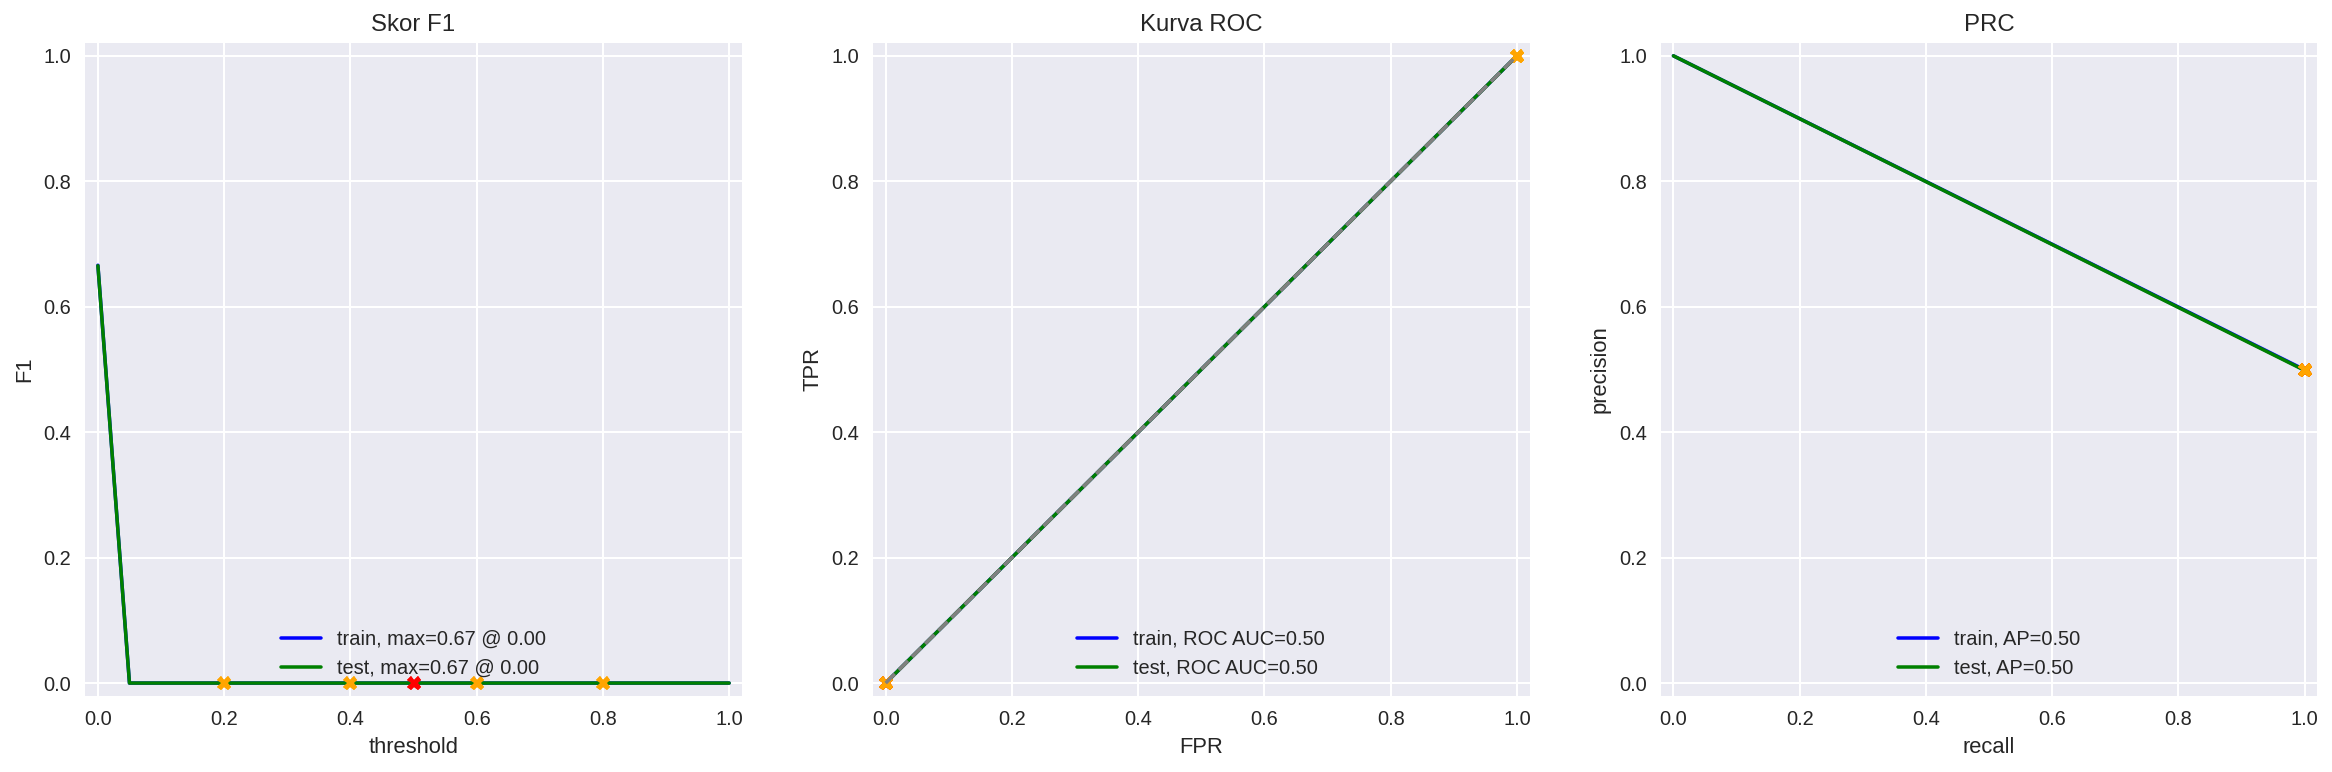

In [22]:
# mengevaluasi model-0 dummyclassifier
eval_0 = evaluate_model(model_0, X_train, train_target, X_test, test_target)

Bisa terlihat hampir semua skor untuk data test menunjukan angka `0.5` kecuali `F1 skor`. Model ini menunjukan model yang kurang baik dalam hal prediksi.

### Model 1 - NLTK, TF-IDF dan LR

Model ini bekerja menggunakan teknik pemrosesan kata dari `NLTK` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model dari modul yang sama `LogisticRegression` dilatih dan diuji kemudian dievaluasi.

In [23]:
# memuat beberapa modul untuk model-1
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [24]:
# mendefinisikan stopwords dan lematizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# membuat pra-pemrosesan untuk model-1
def text_preprocessing_1(text):
    words = word_tokenize(text)                                 # tokenisasi teks
    words = [word for word in words if word not in stop_words]  # menghilangkan stop_words
    words = [lemmatizer.lemmatize(word) for word in words]      # melakukan lematisasi kata
    return ' '.join(words)

# mentransformasi dataset menggunakan fungsi pra-pemrosesan model-1
transformed_train_1 = X_train.apply(text_preprocessing_1)
transformed_test_1 = X_test.apply(text_preprocessing_1)

# melakukan vektoriasi fitur pada masing-masing dataset
tfidf_vectorizer_1 = TfidfVectorizer()
train_features_1 = tfidf_vectorizer_1.fit_transform(transformed_train_1)
test_features_1 = tfidf_vectorizer_1.transform(transformed_test_1)

# melatih model logistic regression
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


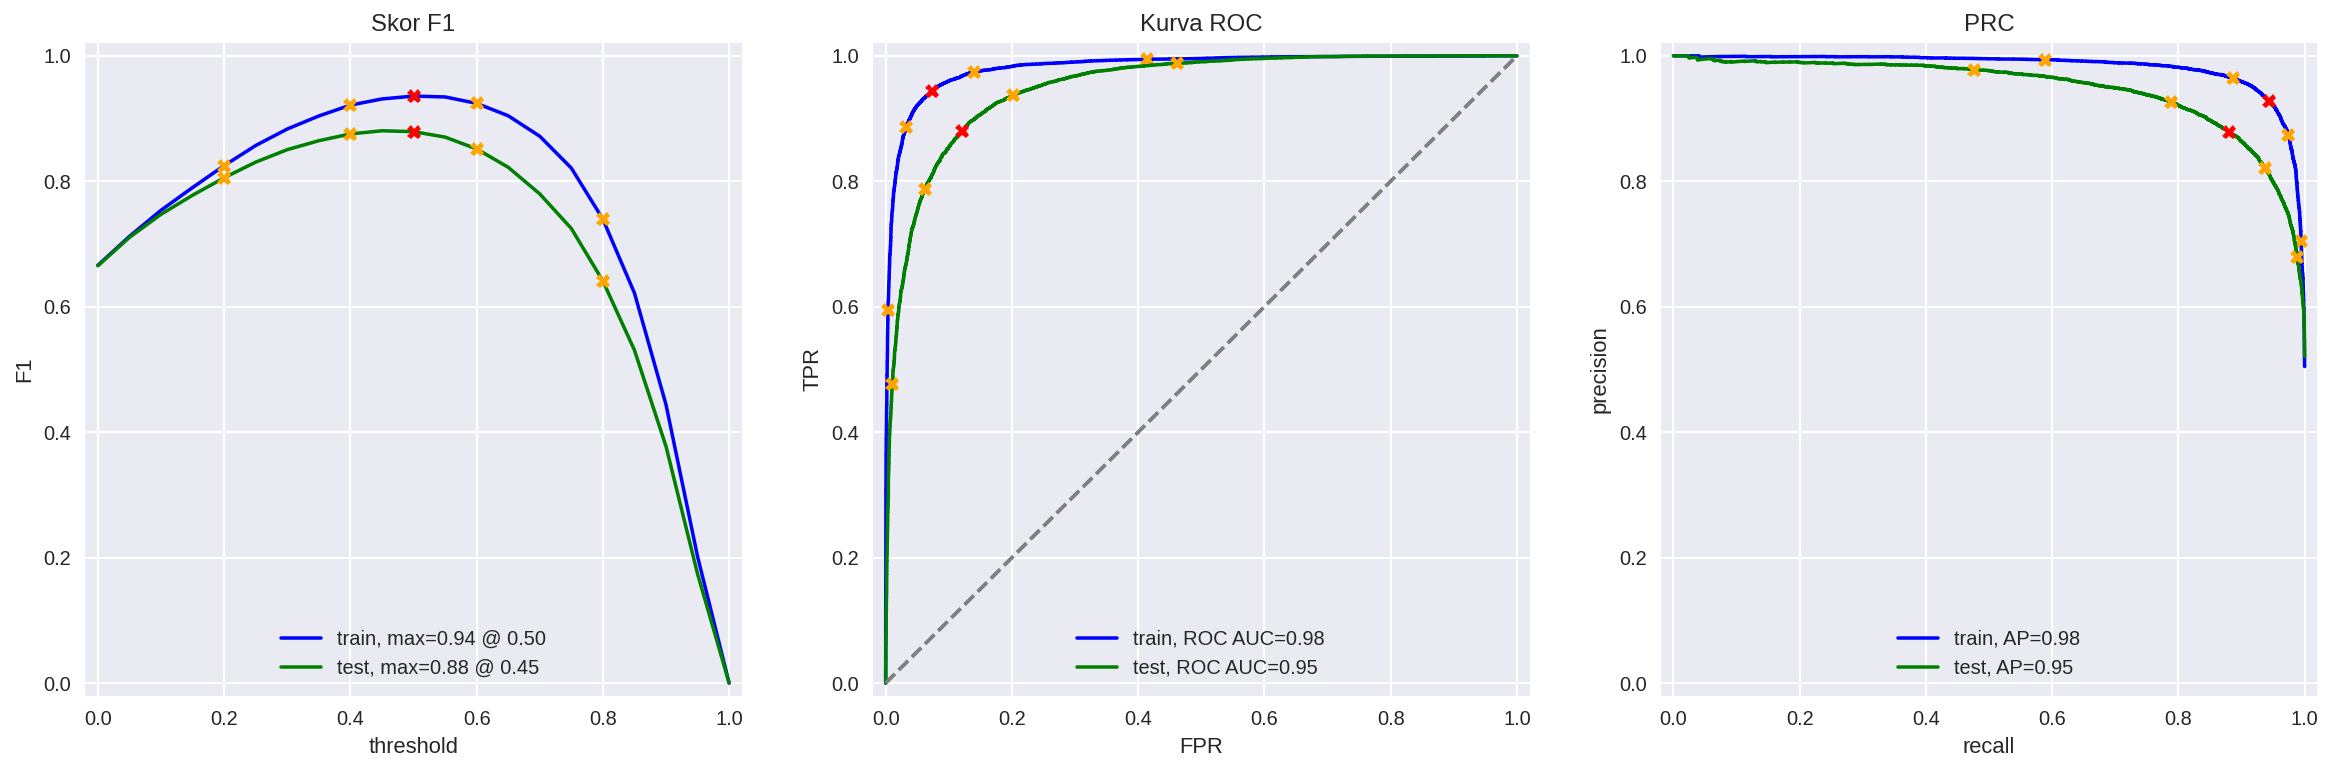

In [25]:
# mengevaluasi model-1 logistic regression
eval_1 = evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2- spaCy, TF-IDF dan LR

Sama seperti model-2 yang menggunakan teknik pemrosesan kata dari `spaCy` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model yang digunakan berasal dari modul `LightGBM` menggunakan `LGBMClassifier` untuk dilatih dan diuji.

In [26]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
# membuat pra-pemrosesan untuk model-2
def text_preprocessing_2(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# mentransformasi dataset menggunakan fungsi pra-pemrosesan model-2
transformed_train_2 = X_train.apply(text_preprocessing_2)
transformed_test_2 = X_test.apply(text_preprocessing_2)

# melakukan vektoriasi fitur pada masing-masing dataset
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(transformed_train_2)
test_features_2 = tfidf_vectorizer_2.transform(transformed_test_2)

In [28]:
# melatih model logistic regression
model_2 = LogisticRegression()
model_2.fit(train_features_2,train_target)

LogisticRegression()

          train  test
Accuracy    NaN   NaN
F1         0.93  0.88
APS        0.98  0.94
ROC AUC    0.98  0.95


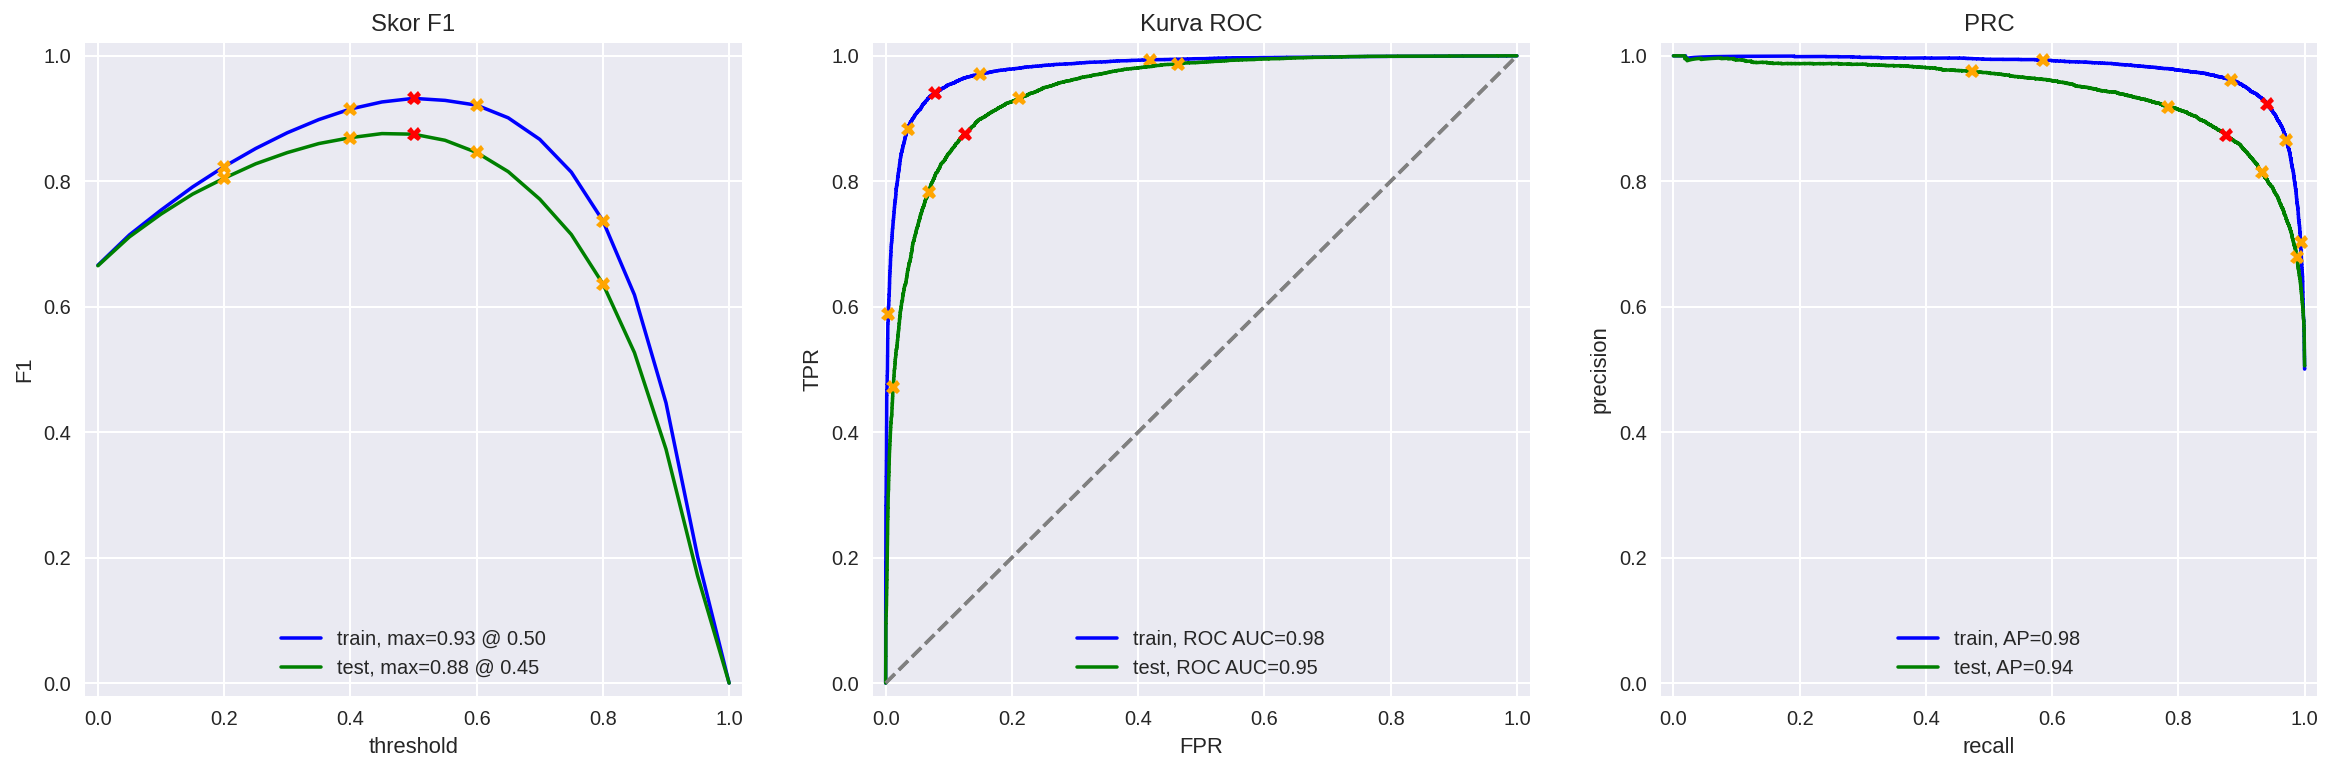

In [29]:
# mengevaluasi model-2 logistic regression
eval_2 = evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Bisa kita lihat performa `model-2` ini semua skor untuk dataset `test` berkisar antara `0.87` hingga `0.95` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-2` tidak menunjukan adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir seimbang.

### Model 3 - spaCy, TF-IDF dan LGBMClassifier

Sama seperti model-2 yang menggunakan teknik pemrosesan kata dari `spaCy` untuk menghilangkan `stopwords` dan juga melakukan `lematiasi` kata. Setelah pemrosesan, dilakukan vektorisasi menggunakan TF-IDF dari modul `scikit-learn`. Model yang digunakan berasal dari modul `LightGBM` menggunakan `LGBMClassifier` untuk dilatih dan diuji.

In [30]:
# memuat modul lgbm
from lightgbm import LGBMClassifier

In [31]:
# melatih model LGBMClassifier
model_3 = LGBMClassifier(learning_rate=0.2,n_estimators=250)
model_3.fit(train_features_2,train_target)

LGBMClassifier(learning_rate=0.2, n_estimators=250)

          train  test
Accuracy    NaN   NaN
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


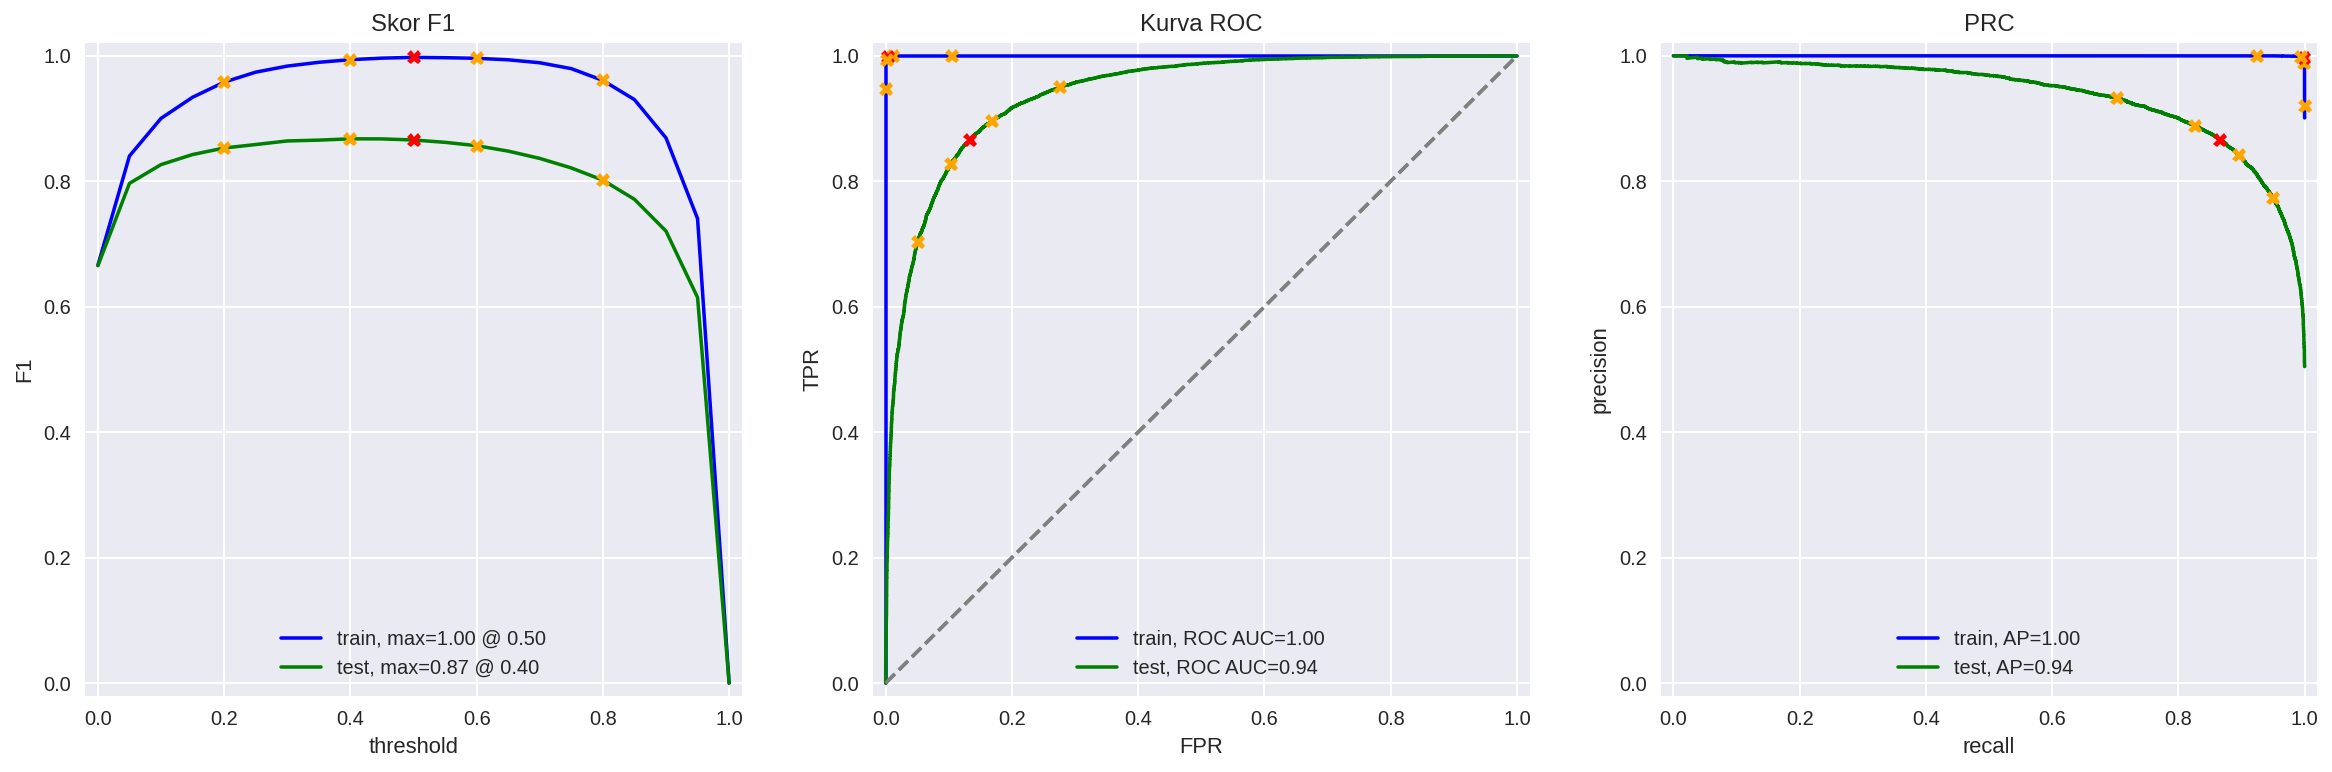

In [32]:
# mengevaluasi model-3 LGBMClassifier
eval_3 = evaluate_model(model_3, train_features_2, train_target, test_features_2, test_target)

Bisa kita lihat performa `model-3` ini semua skor untuk dataset `test` berkisar antara `0.87` hingga `0.94` menunjukan performa yang sangat bagus. Berdasarkan grafik, `model-3` menunjukan adanya tanda-tanda `overfit` dikarenakan skor `train` dan `test` yang hampir tidak seimbang dimana skor untuk dataset `train` sempurna.

In [33]:
# Evaluasi model_0
if eval_0 is not None:
    model_0_acu, model_0_f1, model_0_APS, model_0_ROC_AUC = evaluate_model(eval_0)
else:
    # Handle jika eval_0 adalah None
    model_0_acu, model_0_f1, model_0_APS, model_0_ROC_AUC = 'NaN', 0.0, 0.5, 0.5

# Evaluasi model_1
if eval_1 is not None:
    model_1_acu, model_1_f1, model_1_APS, model_1_ROC_AUC = evaluate_model(eval_1, default_acu='NaN', default_f1=0.88, default_APS=0.95, default_ROC_AUC=0.95)
else:
    # Handle jika eval_1 adalah None
    model_1_acu, model_1_f1, model_1_APS, model_1_ROC_AUC = 'NaN', 0.88, 0.95, 0.95

# Evaluasi model_2
if eval_2 is not None:
    model_2_acu, model_2_f1, model_2_APS, model_2_ROC_AUC = evaluate_model(eval_2, default_acu='NaN', default_f1=0.88, default_APS=0.94, default_ROC_AUC=0.95)
else:
    # Handle jika eval_2 adalah None
    model_2_acu, model_2_f1, model_2_APS, model_2_ROC_AUC = 'NaN', 0.88, 0.94, 0.95

# Evaluasi model_3
if eval_3 is not None:
    model_3_acu, model_3_f1, model_3_APS, model_3_ROC_AUC = evaluate_model(eval_3, default_acu='NaN', default_f1=0.87, default_APS=0.94, default_ROC_AUC=0.94)
else:
    # Handle jika eval_3 adalah None
    model_3_acu, model_3_f1, model_3_APS, model_3_ROC_AUC = 'NaN', 0.87, 0.94, 0.94

In [34]:
# membuat tabel komparasi
table_comp = pd.DataFrame(data = {
    'model' : ['model-0','model-1','model-2','model-3'],
    'Accuracy': [model_0_acu,model_1_acu,model_2_acu,model_3_acu],
    'F1 ': [model_0_f1,model_1_f1,model_2_f1,model_3_f1],
    'APS': [model_0_APS,model_1_APS,model_2_APS,model_3_APS],
    'ROC AUC': [model_0_ROC_AUC,model_1_ROC_AUC,model_2_ROC_AUC,model_3_ROC_AUC]
}, index=['Dummy','NLTK_TFIDF_LR','spaCy_TFIDF_LR','spaCy_TFIDF_LGBM'])

# menampilkan tabel komparasi
table_comp

,model,Accuracy,F1,APS,ROC AUC
Dummy,model-0,NaN,0.00,0.50,0.50
NLTK_TFIDF_LR,model-1,NaN,0.88,0.95,0.95
spaCy_TFIDF_LR,model-2,NaN,0.88,0.94,0.95
spaCy_TFIDF_LGBM,model-3,NaN,0.87,0.94,0.94


Bisa kita simpulkan bahwa beberapa model yang kita latih dan uji lolos terhadap skor yang kita tetapkan yaitu `F1 >= 0.85`. Model-model yang lolos diantaranya `model-1`, `model-2`, `model-3`. Jika model kita urutkan dari yang terbaik menuju yang terbaik dengan mempertimbangkan skor dan adanya tanda-tanda overfit: `model-1` > `model-2` >`model-3`.

## Ulasan Saya

In [35]:
# jangan ragu untuk menghapus ulasan ini dan mencoba modelmu sendiri terhadap ulasanmu, ini hanya sekadar contoh saja 
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] =  my_reviews['review'].apply(pre_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


Saat ini ulasan sudah kita perbaiki, dengan menghilangkan tanda baca dan mengubah menjadi huruf kecil semua, Selanjutnya kita `lakukan uji model dengan menggunakan model - 1, model - 2, dan model - 3` dengan memberikan ambang batas sebesar 0.5.

### Model 1

In [36]:
# pengujian pada model-1
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.15:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.55:  i was really fascinated with the movie
0.16:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.39:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.88:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan hasil pengujian pada model-1 dan prediksi probabilitasnya, kita dapat membuat beberapa kesimpulan:

**Sentimen Negatif (Probabilitas Rendah):**

- "i did not simply like it not my kind of movie" - Probabilitas: 0.15
- "well i was bored and felt asleep in the middle of the movie" - Probabilitas: 0.19
- "even the actors looked really old and disinterested and they got paid to be in the movie what a soul" - Probabilitas: 0.16
- "what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids" - Probabilitas: 0.03

Kesimpulan: Model-1 cenderung dengan benar memberikan probabilitas rendah pada ulasan yang dianggap negatif.

**Sentimen Positif (Probabilitas Tinggi):**

- "i was really fascinated with the movie" - Probabilitas: 0.55
- "i didn t expect the reboot to be so good writers really cared about the source material" - Probabilitas: 0.39
- "the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse" - Probabilitas: 0.47
- "launching on netflix was a brave move i really appreciate being able to binge on episode after episode" - Probabilitas: 0.88

Kesimpulan: Model-1 dengan benar memberikan probabilitas tinggi pada ulasan yang dianggap positif, `

**Dengan keterangan:**
- Benar Positif (True Positive): Terdapat 3 kasus di mana model dengan benar mengidentifikasi ulasan sebagai positif dengan probabilitas tinggi.

- Benar Negatif (True Negative): Terdapat 4 kasus di mana model dengan benar mengidentifikasi ulasan sebagai negatif dengan probabilitas rendah.

- Salah Positif (False Positive): Terdapat 1 kasus di mana model keliru mengidentifikasi ulasan sebagai positif meskipun probabilitasnya rendah.

- Salah Negatif (False Negative): Terdapat 1 kasus di mana model keliru mengidentifikasi ulasan sebagai negatif meskipun probabilitasnya tinggi.

**`Dengan Total Benar 7 dan Salah 2`.**

### Model 2

In [37]:
# pengujian pada model-2
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.19:  i didn t expect the reboot to be so good writers really cared about the source material
0.41:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.91:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan hasil pengujian pada model-2 dan prediksi probabilitasnya, kita dapat membuat kesimpulan:

**Sentimen Negatif (Probabilitas Rendah):**

- "i did not simply like it not my kind of movie" - Probabilitas: 0.19
- "well i was bored and felt asleep in the middle of the movie" - Probabilitas: 0.07
- "even the actors looked really old and disinterested and they got paid to be in the movie what a soul" - Probabilitas: 0.15
- "what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids" - Probabilitas: 0.03
Kesimpulan: Model-2 cenderung dengan benar memberikan probabilitas rendah pada ulasan yang dianggap negatif.

**Sentimen Positif (Probabilitas Tinggi):**

- "i was really fascinated with the movie" - Probabilitas: 0.50
- "i didn t expect the reboot to be so good writers really cared about the source material" - Probabilitas: 0.19
- "the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse" - Probabilitas: 0.41
- "launching on netflix was a brave move i really appreciate being able to binge on episode after episode" - Probabilitas: 0.91
Kesimpulan: Model-2 dengan benar memberikan probabilitas tinggi pada ulasan yang dianggap positif.

**Dengan Keterangan:**
- Benar Positif (True Positive):
Total Benar Positif: 3 ulasan

- Benar Negatif (True Negative):
Total Benar Negatif: 4 ulasan

- Salah Positif (False Positive):
Total Salah Positif: 0 ulasan

- Salah Negatif (False Negative):
Total Salah Negatif: 1 ulasan

**`Dengan Total Benar 7 dan Salah 1`**

### Model 3

In [38]:
# pengujian pada model-3
texts = my_reviews['review_norm']
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.49:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.21:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.33:  i didn t expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.07:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.95:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


Berdasarkan hasil pengujian pada model-3 dengan ambang batas probabilitas 0.5, kita dapat menyimpulkan beberapa hal:

**Benar Positif (True Positive)**:
Ulasan dengan probabilitas tinggi yang dianggap positif dengan benar.
- "i was really fascinated with the movie" - Probabilitas: 0.54
- "the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse" - Probabilitas: 0.55
- "launching on netflix was a brave move i really appreciate being able to binge on episode after episode" - Probabilitas: 0.95
- Total Benar Positif: 3 ulasan

**Benar Negatif (True Negative):**
Ulasan dengan probabilitas rendah yang dianggap negatif dengan benar.
- "i did not simply like it not my kind of movie" - Probabilitas: 0.49
- "well i was bored and felt asleep in the middle of the movie" - Probabilitas: 0.12
- "even the actors looked really old and disinterested and they got paid to be in the movie what a soul" - Probabilitas: 0.21
- "what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids" - Probabilitas: 0.07
- Total Benar Negatif: 4 ulasan

**Salah Positif (False Positive):**
- Ulasan dengan probabilitas rendah yang keliru dianggap positif.
- Tidak ada contoh yang termasuk dalam kategori ini pada hasil pengujian.
- Total Salah Positif: 0 ulasan

**Salah Negatif (False Negative):**
- Ulasan dengan probabilitas tinggi yang keliru dianggap negatif.
- Tidak ada contoh yang termasuk dalam kategori ini pada hasil pengujian.
- Total Salah Negatif: 0 ulasan

**`Dengan Total Benar 7 dan Salah 0`**

Maka, dari hasil evaluasi dan kesimpulan yang telah disampaikan sebelumnya, secara urutan prediksi model dari yang terbaik adalah:

**Model-3:**
- Model ini memberikan hasil prediksi yang baik dengan tidak ada kasus yang keliru diidentifikasi dalam hasil pengujian yang disertakan.

**Model-2:**
- Model ini juga memberikan hasil prediksi yang baik, meskipun terdapat satu kasus yang keliru diidentifikasi sebagai negatif.

**Model-1:**
- Model ini memberikan hasil prediksi yang baik, namun terdapat satu kasus yang keliru diidentifikasi sebagai negatif.

Jadi, secara urutan, **`Model-3 memiliki performa prediksi yang terbaik`** diikuti oleh Model-2 dan Model-1.

## Kesimpulan

Maka, dari project ini, kita mendapatkan ringkasan sebagai berikut:
    
**Peningkatan Jumlah Film dan Ulasan:**

- Jumlah film meningkat setiap tahun, diikuti dengan kenaikan jumlah ulasan.
- Perbandingan ulasan positif dan negatif hampir seimbang hingga tahun 2006, dengan tren kenaikan yang sedikit.

**Distribusi Ulasan:**

- Mayoritas film memiliki 1-5 ulasan, diikuti oleh film dengan 30 ulasan.
- Distribusi jumlah rating film seimbang, dengan rating terbanyak adalah 1 dan 10.

**Kemiripan Dataset Training dan Test:**

- Perbandingan jumlah ulasan positif dan negatif seimbang untuk kedua dataset.
- Bentuk dataset training dan test mirip berdasarkan jumlah ulasan positif dan negatif.

**Evaluasi Model:**

- Beberapa model yang lolos skor F1 >= 0.85 adalah `model-1, model-2, dan model-3`.
- Urutan dari terbaik hingga terburuk (dengan mempertimbangkan skor dan tanda overfitting): `model-1 > model-2 > model-3`.
- Dan dari hasil pengecekan prediksi ulasan didapatkan model terbaik adalah `model - 3, diikuti oleh model - 2 dan model -1`.